In [1]:
import os
import numpy as np
import importlib
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
!ls ~/git/analysis_playground/ml/data/training_data

ls: cannot access /SNS/users/imeliamb/git/analysis_playground/ml/data/training_data: No such file or directory


In [3]:
data_dir = os.path.expanduser("~m2d/git/analysis_playground/ml/data/training_data")

pars = np.load(os.path.join(data_dir, "orhs2-pars_pars.npy"))
refl = np.load(os.path.join(data_dir, "orhs2-pars_data.npy"))
q_values = np.load(os.path.join(data_dir, "orhs2-pars_q_values.npy"))

N_LAYERS = 2
print(pars.shape)
print(refl.shape)
print(q_values.shape)

refl_corrected = np.power(10, refl)/q_values**2*q_values[0]**2

idx = 0


(2000000, 7)
(2000000, 100)
(100,)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


index 0 [[ 0.60213064 -0.53129868 -0.81568903 -0.62652524 -0.12935493  0.01059685
  0.83656137]]


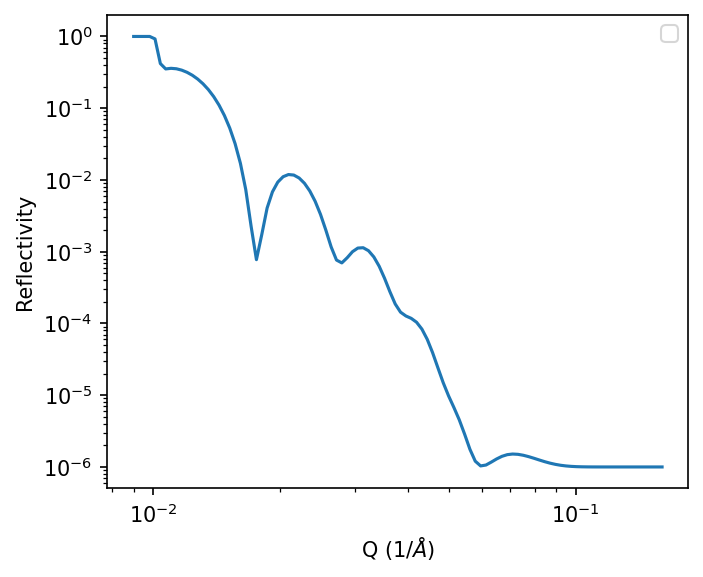

In [4]:
print("index %s [%s]" % (idx, pars[idx]))

fig, ax = plt.subplots(dpi=150, figsize=(5, 4.1))
plt.plot(q_values, refl_corrected[idx])
plt.xlabel('Q ($1/\AA$)', fontsize=10)
plt.ylabel('Reflectivity', fontsize=10)
plt.yscale('log')
plt.xscale('log')
plt.legend()
idx += 1



```
{"i": 0, "par": "roughness", "bounds": [4, 30]},
{"i": 1, "par": "sld", "bounds": [-1, 7]},
{"i": 1, "par": "thickness", "bounds": [20, 950]},
{"i": 1, "par": "roughness", "bounds": [20, 60]},
{"i": 2, "par": "sld", "bounds": [-1, 7]},
{"i": 2, "par": "thickness", "bounds": [50, 950]},
{"i": 2, "par": "roughness", "bounds": [20, 60]}
```

In [5]:
import refl1d
from refl1d.names import *
from bumps.fitters import fit

def create_fit_experiment(q, parameters, data=None, errors=None, q_resolution=0.025):
    #zeros = np.zeros(len(q))
    dq = q_resolution * q / 2.355

    # The QProbe object represents the beam
    probe = QProbe(q, dq, data=(data, errors))
    probe.background = Parameter(value=0.000001,name='background')
    
    n_layers = int((len(parameters)-1)/3)
    
    sample = Slab(material=SLD('Si', rho=2.07), interface=parameters[0])
    
    for i in range(n_layers):
        sample = sample | Slab(material=SLD(name='l%s' % i, rho=parameters[3*i+1]),
                               thickness=parameters[3*i+2], interface=parameters[3*i+3])
        sample['l%s' % i].thickness.range(20.0, 950.0)
        sample['l%s' % i].material.rho.range(-1.0, 7.0)
        sample['l%s' % i].interface.range(20.0, 60.0)

    sample['Si'].interface.range(4.0, 30.0)
    sample = sample | Slab(material=SLD('Air', rho=0))
    
    return Experiment(probe=probe, sample=sample)
    

def calculate_reflectivity(q, parameters, q_resolution=0.02):
    """
        Reflectivity calculation using refl1d
    """

    expt = create_fit_experiment(q, parameters, q_resolution=0.02)
    q, r = expt.reflectivity()
    z, sld, _ = expt.smooth_profile()
    return q, r, z, sld


def fit_data(q, data, errors, parameters, q_resolution=0.025):
    expt = create_fit_experiment(q, parameters, data, errors, q_resolution=0.02)
    problem = FitProblem(expt)
    results = fit(problem, method='dream', samples=2000, burn=2000, pop=20, verbose=True)
    #print(results)
    
    # The results are in a different order: rough, SLD, thickness
    fit_pars = [results.x[0]]
    fit_errs = [results.dx[0]]

    n_layers = int((len(parameters)-1)/3)
    for i in range(n_layers):
        fit_pars.extend([results.x[3*i+2], results.x[3*i+3], results.x[3*i+1]]) 
        fit_errs.extend([results.dx[3*i+2], results.dx[3*i+3], results.dx[3*i+1]])
    return fit_pars, fit_errs
    

In [6]:
q, r, z, sld = calculate_reflectivity(q_values, [10, 5, 250, 15])

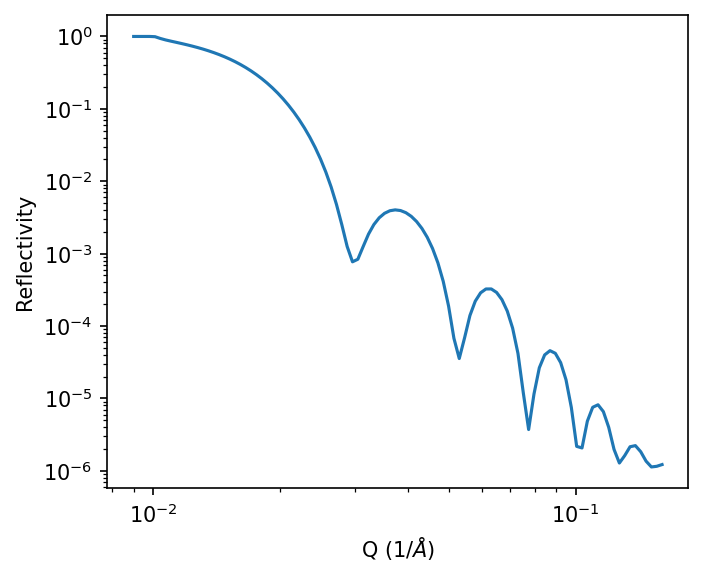

In [7]:
fig, ax = plt.subplots(dpi=150, figsize=(5, 4.1))
plt.plot(q_values, r)
plt.xlabel('Q ($1/\AA$)', fontsize=10)
plt.ylabel('Reflectivity', fontsize=10)
plt.yscale('log')
plt.xscale('log')

In [8]:
sys.path.append(os.path.expanduser("~/git/machine_learning/src"))
import structure_predictor as sp
import models

2023-09-20 09:00:32.834040: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-20 09:00:32.910258: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


[-0.44515039  0.23169454  0.15081926 -0.31214407 -0.29517403  0.43874862
  0.12951536]
1/1 [==============================] - 0s 293ms/step
[-0.35319722  0.21756087  0.16966295 -0.20418006 -0.32738245  0.5816361
  0.08074364]
# steps: 15, # draws: 2100
step 1 cost 148.529(88)
                            Si interface ...|......    12.4084 in (4,30)
                            l0 interface ...|......    35.9164 in (20,60)
                                  l0 rho ......|...    3.87025 in (-1,7)
                            l0 thickness .....|....    563.892 in (20,950)
                            l1 interface .....|....    41.6149 in (20,60)
                                  l1 rho ...|......    1.69048 in (-1,7)
                            l1 thickness .......|..    761.735 in (20,950)
step 17 cost 144.836(88)
step 33 cost 69.739(88)
step 49 cost 3.927(88)
step 66 cost 1.462(88)
step 83 cost 0.727(88)
step 99 cost 0.262(88)
step 114 cost 74(88)e-3
step 128 cost 74(88)e-3
step 145 cost 74(

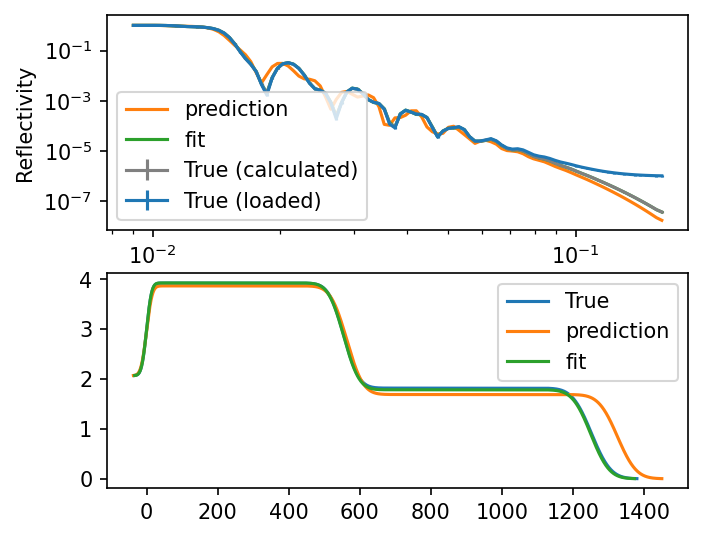

In [9]:
importlib.reload(sp)
idx+=1


predictor = sp.StructurePredictor(os.path.expanduser("~m2d/git/machine_learning/src/settings.json"),1)

cnn_model = predictor.parameter_predictors[2]

print(pars[idx])

predicted_pars = cnn_model.predict(np.asarray([refl[idx]]))
print(predicted_pars[0])
predicted_pars = predictor.rescale_real_pars(predicted_pars, 2)

real_parameters = predictor.rescale_real_pars([pars[idx]], 2) 

fig, ax = plt.subplots(2, 1, dpi=150, figsize=(5, 4.1))
q, r, z, sld = sp.calculate_reflectivity(q_values, real_parameters[0])

plt.subplot(2,1,1)
plt.errorbar(q_values, r, yerr=0.07*r, label='True (calculated)', color='grey')
plt.errorbar(q_values, refl_corrected[idx], yerr=0.07*refl_corrected[idx], label='True (loaded)')
plt.subplot(2,1,2)
plt.plot(z, sld, label='True')



fit_pars, fit_errs = fit_data(q_values, refl_corrected[idx], 0.07*refl_corrected[idx], predicted_pars[0])
#fit_pars, fit_errs = fit_data(q_values, refl[idx], 0.07*refl[idx], real_parameters[0])

q, r, z, sld = sp.calculate_reflectivity(q_values, predicted_pars[0])
plt.subplot(2,1,1)
plt.plot(q_values, r, label='prediction')
plt.subplot(2,1,2)
plt.plot(z, sld, label='prediction')


q, r, z, sld = sp.calculate_reflectivity(q_values, fit_pars)
plt.subplot(2,1,1)
plt.plot(q_values, r, label='fit')
plt.subplot(2,1,2)
plt.plot(z, sld, label='fit')

print()

plt.subplot(2,1,1)
plt.xlabel('Q ($1/\AA$)', fontsize=10)
plt.ylabel('Reflectivity', fontsize=10)
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.subplot(2,1,2)
plt.legend()


for i in range(len(real_parameters[0])):
    print("%-6.2f \t %-6.2f \t %-6.2f +- %-6.2f" % (real_parameters[0][i], predicted_pars[0][i], fit_pars[i], fit_errs[i]))

32/32 [==============================] - 0s 2ms/step


Text(0.5, 0, 'a for index 1')

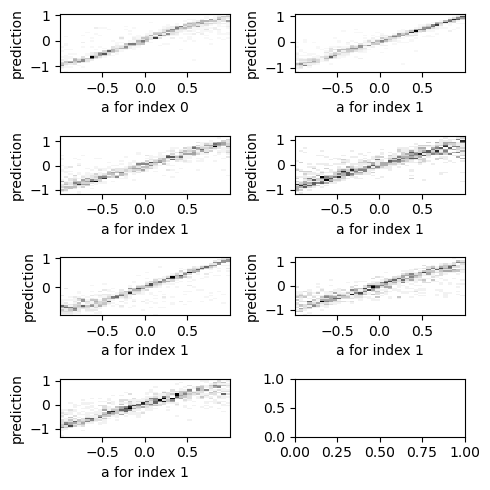

In [174]:
cnn_model=models.load_model("cnn2layer", os.path.expanduser("~m2d/git/machine_learning/data"))

preds=cnn_model.predict(refl[:1000])

n_bins=40

fig, axs= plt.subplots(4,2, sharey=False, tight_layout= True, dpi=100, figsize= (5,5))
true_values=pars[:1000]

ax=plt.subplot(4, 2, 1)
ax.hist2d(true_values[:,0], preds[:,0], bins=n_bins, cmap= "Greys")
plt.ylabel('prediction')
plt.xlabel('a for index 0')

ax=plt.subplot(4, 2, 2)
ax.hist2d(true_values[:,1], preds[:,1], bins=n_bins, cmap= "Greys")
plt.ylabel('prediction')
plt.xlabel('a for index 1')

ax=plt.subplot(4, 2, 3)
ax.hist2d(true_values[:,2], preds[:,2], bins=n_bins, cmap= "Greys")
plt.ylabel('prediction')
plt.xlabel('a for index 1')


ax=plt.subplot(4, 2, 4)
ax.hist2d(true_values[:,3], preds[:,3], bins=n_bins, cmap= "Greys")
plt.ylabel('prediction')
plt.xlabel('a for index 1')


ax=plt.subplot(4, 2, 5)
ax.hist2d(true_values[:,4], preds[:,4], bins=n_bins, cmap= "Greys")
plt.ylabel('prediction')
plt.xlabel('a for index 1')


ax=plt.subplot(4, 2, 6)
ax.hist2d(true_values[:,5], preds[:,5], bins=n_bins, cmap= "Greys")
plt.ylabel('prediction')
plt.xlabel('a for index 1')


ax=plt.subplot(4, 2, 7)
ax.hist2d(true_values[:,6], preds[:,6], bins=n_bins, cmap= "Greys")
plt.ylabel('prediction')
plt.xlabel('a for index 1')


